# 1 Neural networks with PyTorch

PyTorch is compiled in different versions for different systems. When working locally, check out the PyTorch [Get Started Guide](https://pytorch.org/get-started/locally/) to install PyTorch with the appropriate CUDA version for your system.

In [1]:
import torch

_ = torch.manual_seed(42)

## 1.1 Working with tensors

In their most basic form, tensors are just multi-dimensional arrays.

In [2]:
t = torch.tensor([1, 2, 3])

Tensors can be stored on different devices, such as CPU or GPU. PyTorch provides a simple way to move tensors between devices using the `.to()` method. This is useful for leveraging the computational power of GPUs for deep learning tasks.

In [3]:
t.device

device(type='cpu')

In [4]:
t.to(device='cuda:0')

tensor([1, 2, 3], device='cuda:0')

As in Numpy, tensors support many data types, including `float`, `int`, and `bool`. A full list of data types can be found in the [PyTorch documentation](https://pytorch.org/docs/stable/tensors.html#torch-tensor-dtypes). When working with floats, 32-bit floats are most common.

To save memory, 16-bit floats can also be used, in what is sometimes termed "lower precision" or "mixed precision". This is especially useful when training large models on GPUs, as it can significantly reduce memory usage and speed up training. 

While less common in deep learning tasks, 64-bit floats can also be used for high-precision calculations.

In [5]:
t.dtype

torch.int64

In [6]:
t.to(dtype=torch.float32)

tensor([1., 2., 3.])

What really sets apart tensors from Numpy arrays is that they can automatically record every operation performed on them. In other words, they build a *computation graph*, which is a directed acyclic graph tracing how each tensor value was computed. This graph is what enables *automatic differentiation*, the core mechanism behind *back-propagation* in neural-network training.

Every time you combine or transform tensors, PyTorch notes that operation and links the inputs and outputs in its graph. Once you’ve computed some final output (for instance, a loss), you call `.backward()`, and PyTorch traverses the graph in reverse to compute gradients - the derivatives of that output with respect to each tensor marked for tracking. Those gradients tell you how to adjust your model’s parameters to reduce the loss. Without a recorded graph, you’d have to derive and implement each derivative by hand.

Back propagation will be covered later in this tutorial. For now, it is important to know that:

1. Tensors can keep track of all operations that lead to the resulting values.
2. This graph is used to compute the gradients of the loss function with respect to the model parameters.
3. Gradients are essentially a combination of derivatives, which are used to update the model parameters during training.

We can enable gradient tracking by setting the `requires_grad` attribute to `True`. Lets perform a simple operation:

In [7]:
t = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
out = t.pow(2).sum()
out

tensor(14., grad_fn=<SumBackward0>)

The grad_fn attribute of the tensor shows the function that created it. In this case, it is a `SumBackward` function, which indicates that the tensor was created by summing two other tensors.

Calling `.backward()` on the tensor will compute the gradients of all tensors that have `requires_grad=True` and are part of the computation graph leading to this tensor. The gradients will be stored in the `.grad` attribute of those tensors.

In [8]:
out.backward()
t.grad

tensor([2., 4., 6.])

Indeed, calling `.backward()` on the `out` tensor computes the gradients of `out` with respect to `t`, and stores them in `t.grad`. The gradient (or derivatives) of the sum of squares with respect to each element is `2 * t[i]`, so for `t = [1.0, 2.0, 3.0]`, the gradients will be `[2.0, 4.0, 6.0]`.

*Assignment 1: Create a tensor with `requires_grad=True` and perform a sequence of operations on it. Then, call backward() and check the gradient.*

In [9]:
# Add your own code here

More information on tensors can be found in the [PyTorch documentation](https://docs.pytorch.org/docs/stable/tensors.html#initializing-and-basic-operations), including a full list of tensor operations. You can also check the [PyTorch tutorial on tensor basics](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html) for more examples and explanations.

## 1.2 Handling data sets in PyTorch


### 1.2.1 Exploring the breast cancer dataset

The breast cancer dataset is a classic dataset for binary classification tasks. It contains features extracted from images of breast cancer tumors, along with labels indicating whether the tumor is malignant or benign. As the features have already been extracted and processed into a numerical format, the dataset is ideal for a simple neural network classification task.

The dataset is available in the [`sklearn.datasets`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) module, and can be loaded using the [`load_breast_cancer()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer) function. 

In [10]:
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_breast_cancer

In [11]:
cancer_data = load_breast_cancer(as_frame=True)
features = cancer_data['data']
targets = cancer_data['target']
target_names = cancer_data['target_names']
feature_names = cancer_data['feature_names']

Let's check out the target classes:

In [12]:
for i, name in enumerate(target_names):
    print(i, name)

0 malignant
1 benign


And lets see how many data points we have for each class:

In [13]:
targets.value_counts()

target
1    357
0    212
Name: count, dtype: int64

*Question: Is the dataset balanced? What does that imply for the training task?*

Let's check out the features:

In [14]:
features.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


And let's visualize some of them:

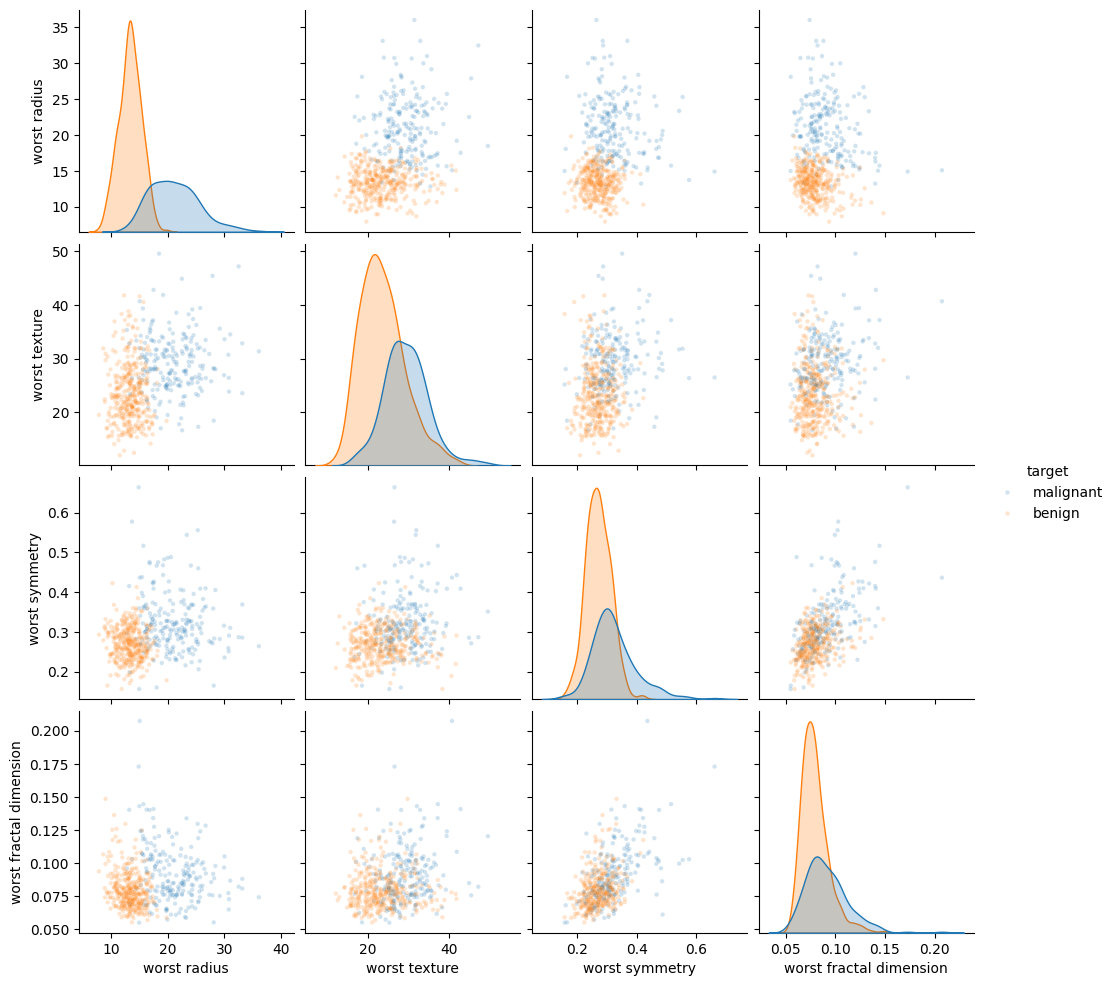

In [15]:
data = pd.concat([features, targets.astype(bool).map({False: "malignant", True: "benign"})], axis=1)

sns.pairplot(
    data[["worst radius", "worst texture", "worst symmetry", "worst fractal dimension", "target"]],
    hue="target",
    diag_kind='kde',
    plot_kws={"alpha": 0.2, "s": 10},
)

We can see that these features show some separation between the two classes, but not all of them are equally useful. For example, "worst fractal dimension" is not as informative as "worst radius". The neural network will allow us to combine these features in a way that maximizes the separation between the two classes.

### 1.2.2 Creating a data set object

Data handling for deep learning is a bit different from regular machine learning. In deep learning, we often work with large datasets that are too big to fit into memory all at once. Instead, we load the data in batches, which allows us to train both save memory and speed up the training process. The latter is possible applying gradient descent per batch instead of for the entire dataset at once.

PyTorch provides to convenient helper classes for handling data: [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). The former is an abstract class that represents a single dataset, while the latter class is used to load data from a dataset in batches.

In [16]:
from torch.utils.data import Dataset

As we already loaded the data into a Pandas DataFrame, the initialization of the dataset is straightforward. We just need to convert the DataFrame into a PyTorch tensor with the correct data types. The `__getitem__` method is used to retrieve a single sample from the dataset, while the `__len__` method returns the total number of samples in the dataset.

In [17]:
class CancerDataset(Dataset):
    def __init__(self, features: pd.DataFrame, targets: pd.Series):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.targets[idx]
        return x, y

cancer_dataset = CancerDataset(features, targets)

Now the dataset can be accessed by index, just like a list. Each item is a tuple containing the features and targets as tensors.

In [18]:
cancer_dataset[0]

(tensor([1.7990e+01, 1.0380e+01, 1.2280e+02, 1.0010e+03, 1.1840e-01, 2.7760e-01,
         3.0010e-01, 1.4710e-01, 2.4190e-01, 7.8710e-02, 1.0950e+00, 9.0530e-01,
         8.5890e+00, 1.5340e+02, 6.3990e-03, 4.9040e-02, 5.3730e-02, 1.5870e-02,
         3.0030e-02, 6.1930e-03, 2.5380e+01, 1.7330e+01, 1.8460e+02, 2.0190e+03,
         1.6220e-01, 6.6560e-01, 7.1190e-01, 2.6540e-01, 4.6010e-01, 1.1890e-01]),
 tensor(0.))

Learn more about Datasets on the [PyTorch documentation](https://pytorch.org/docs/stable/data.html).

### 1.2.3 Creating a data loader

PyTorch provides a convenient way to load data in batches using the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class. It takes a `Dataset` object and provides an iterable over the dataset, allowing you to easily iterate over the data in batches. Training data can be immediately shuffled by the `DataLoader`, which is useful for training models. The `DataLoader` class also provides options for parallel data loading, which can speed up the training process if data parsing is computationally expensive.

In [19]:
from torch.utils.data import DataLoader
cancer_dataloader = DataLoader(cancer_dataset, batch_size=32, shuffle=True)

To test the dataloader, we can iterate over the data. Each iteration yields a batch of data, which is a tuple containing the features and labels.

In [20]:
for batch_x, batch_y in cancer_dataloader:
    print(batch_x.shape, batch_y.shape)
    break

torch.Size([32, 30]) torch.Size([32])


Learn more about `DataLoader` on the [PyTorch documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) and check out the [PyTorch tutorial on data loading and processing](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

*Question: Go to the documentation and look up the difference between an iterable and map-style dataset. When would you use one over the other? What are the advantages and disadvantages of each?*

## 1.3 Building a simple linear classifier

### 1.3.1 Creating a Pytorch model object to define the model architecture

The [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) class is the base class for all neural network modules in PyTorch. It provides a convenient way to define and manage the architecture and all parameters of your model, as well as to define the forward pass of your model.
The `__init__` method is where you define the layers of your model. In this case, we are using a single linear layer with 30 input features and 2 output features. The `forward` method defines the forward pass of your model, which takes in the input data and passes it through the layers defined in the `__init__` method.

A `backward` method is not needed, as PyTorch automatically computes the gradients for you when you call `.backward()` on the output of your model. The backward steps are inferred using the computation graph.

In [21]:
from torch import nn

class BreastCancerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(30, 1)

    def forward(self, x):
        x = self.layer1(x)
        return x

*Question: What are the numbers 30 and 1 in the [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) constructor? Why were they chosen?*

In [22]:
model = BreastCancerClassifier()
model.forward(batch_x).shape

torch.Size([32, 1])

### 1.3.2 The loss function

The loss function is simply a measure of how well the model is performing. PyTorch provides a variety of loss functions in the [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions) module, including mean squared error (MSE), cross-entropy loss, and binary cross-entropy loss. The choice of loss function depends on the type of problem you are trying to solve. For example, if you are working on a regression problem, you would typically use MSE, while for a classification problem, you would use cross-entropy loss.

In this case, we are using binary cross-entropy loss. Its values are between 0 and 1, where 0 means the model is perfect and 1 means the model is completely wrong. The closer the value is to 0, the better the model is performing. The following blog post provides a great visual explanation of the binary cross-entropy loss function: [Understanding binary cross-entropy / log loss: a visual explanation | Towards Data Science](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a).

In [23]:
loss_function = nn.BCEWithLogitsLoss()

We can also calculate the ROC-AUC score on the entire validation set using the [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) function from `sklearn.metrics`.

In [24]:
from sklearn.metrics import roc_auc_score

### 1.3.3 The optimizer

The optimizer is the algorithm that adjusts the parameters of a model to minimize the loss function. It takes the gradients computed during the backward pass and 
determines how to use them to update the model parameters. The most important hyperparameter for the optimizer is the learning rate, which controls how much to adjust the parameters at each step. A smaller learning rate means smaller updates, while a larger learning rate means larger updates. 

In PyTorch, optimizers are implemented as classes in the [`torch.optim`](https://pytorch.org/docs/stable/optim.html#algorithms) module. The most common optimizer is *stochastic gradient descent (SGD)*, but there are many other optimizers available, such as Adam, RMSprop, and Adagrad. Each has its own advantages and disadvantages, and the choice of optimizer can have a significant impact on the performance of your model.

When setting up the optimizer, you need to pass in the parameters of your model that you want to optimize. In this case, we are passing in the parameters of the `model` object. The optimizer will then update these parameters during training.

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### 1.3.4 The training loop
The training loop is the core of the training process. It goes through the following steps:

1. Get a batch of data from the `DataLoader`.
2. Zero the gradients of the model parameters using `optimizer.zero_grad()`. Otherwise, the gradients would accumulate over multiple iterations, which is not what we want.
3. Perform a forward pass through the model to get its current predictions.
4. Compute the loss.
5. Perform a backward pass to compute the gradients.
6. Update the model parameters using the optimizer.

Here, we implement a single training step:

In [26]:
for batch_x, batch_y in cancer_dataloader:                  # 1. Get a batch of data
    optimizer.zero_grad()                                   # 2. Reset gradients
    y_pred = model(batch_x)                                 # 3. Forward pass
    loss_value = loss_function(y_pred.squeeze(), batch_y)   # 4. Compute loss
    loss_value.backward()                                   # 5. Backward pass, based on the loss
    optimizer.step()                                        # 6. Update weights

    break  # For demonstration, we only do one batch

print(f"{loss_value.item():.4f}")

17.0411


*Note: [`squeeze()`](https://pytorch.org/docs/stable/generated/torch.squeeze.html#torch-squeeze) is used to remove the extra dimension from the output of the model. The model outputs a tensor of shape `(batch_size, 1)`, but we want it to be of shape `(batch_size,)` for the loss function.*

### 1.3.3 Training a model

Of course, we want to train the model for multiple *epochs*. An epoch is a complete pass through the training data. In each epoch, we will go through all the batches of data in the `DataLoader` and perform the training steps described above. Additionally, we want to see how the model is performing on the *validation set*. To do this, we will perform a single forward step with the current model on a validation dataset and compute the loss after each epoch.

*Question: What is the difference between a validation set and a test set? Why do we need both? When do you use one over the other?*

To split our data into a training and validation set, we can use the [`random_split`](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) function.

In [27]:
data_train, data_validation = torch.utils.data.random_split(cancer_dataset, [0.8, 0.2])

dataloader_train = DataLoader(data_train, batch_size=32, shuffle=True)
dataloader_validation = DataLoader(data_validation, batch_size=32, shuffle=False)

Complete the code below to train the model. Add the train step and validation step to the training loop. Take into account that not all points from the training step are needed in the validation step.

Epoch 1: Train Loss: 0.6816, Validation Loss: 0.6585
Epoch 2: Train Loss: 0.6739, Validation Loss: 0.3741
Epoch 3: Train Loss: 0.6314, Validation Loss: 0.4373
Epoch 4: Train Loss: 0.6441, Validation Loss: 0.3571
Epoch 5: Train Loss: 0.5420, Validation Loss: 0.3730
Epoch 6: Train Loss: 0.6460, Validation Loss: 0.3751
Epoch 7: Train Loss: 0.5068, Validation Loss: 0.3550
Epoch 8: Train Loss: 0.5126, Validation Loss: 0.3485
Epoch 9: Train Loss: 0.4634, Validation Loss: 0.3235
Epoch 10: Train Loss: 0.5104, Validation Loss: 0.3431
ROC-AUC score: 0.9719


<Axes: title={'center': 'Losses'}, xlabel='Epoch', ylabel='Loss'>

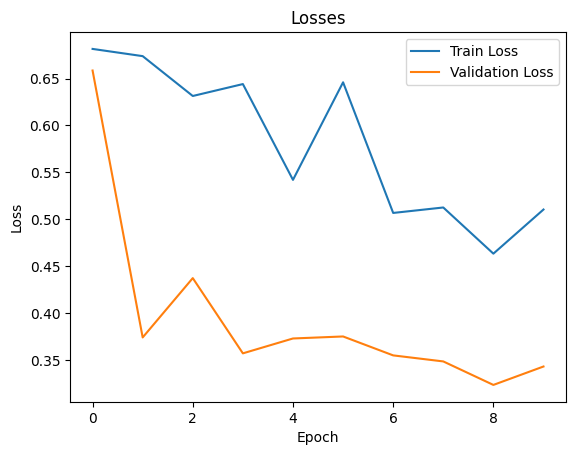

In [28]:
model = BreastCancerClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.BCEWithLogitsLoss()

# We will train the model for 100 epochs
n_epochs = 10
train_losses = []
validation_losses = []

for epoch in range(1, n_epochs + 1):
    # Train the model
    model.train()
    epoch_loss_train = 0  # Accumulate the loss for this epoch
    for batch_x, batch_y in dataloader_train:
        # Add your code here for a single training step. Make sure the loss is placed in
        # the loss_value variable.
        # ---
        optimizer.zero_grad()
        y_pred = model(batch_x)
        loss_value = loss_function(y_pred.squeeze(), batch_y)
        loss_value.backward()
        optimizer.step()
        # ---
        epoch_loss_train += loss_value.item()

    avg_epoch_loss_train = epoch_loss_train / len(dataloader_train)  # Average loss for the epoch
    train_losses.append(avg_epoch_loss_train)

    # Evaluate the model
    model.eval()
    epoch_loss_validation = 0
    with torch.no_grad():
        for batch_x, batch_y in dataloader_validation:
            # Add your code here for a single validation step. Make sure the loss is placed in
            # the loss_value variable.
            # ---
            y_pred = model(batch_x)
            loss_value = loss_function(y_pred.squeeze(), batch_y)
            # ---
            epoch_loss_validation += loss_value.item()

    avg_epoch_loss_validation = epoch_loss_validation / len(dataloader_validation)
    validation_losses.append(avg_epoch_loss_validation)

    print(f"Epoch {epoch}: Train Loss: {avg_epoch_loss_train:.4f}, Validation Loss: {avg_epoch_loss_validation:.4f}")

# Calculate the AUC score on the full validation set
x = data_validation[:][0]
y = data_validation[:][1]
y_pred = model(x)
print(f"ROC-AUC score: {roc_auc_score(y.numpy(), y_pred.detach().numpy()):.4f}")

# Plot the learning curves
pd.DataFrame({
    "Train Loss": train_losses,
    "Validation Loss": validation_losses,
}).plot(title="Losses", xlabel="Epoch", ylabel="Loss")

If everything is working correctly, you should see the train loss decreasing over time. The model should also be able to predict the labels of the validation set with a some accuracy.

## 1.4 Building a linear deep neural network

So far, we have built a simple linear classifier. However, in practice, we often want to build more complex models that can learn more intricate patterns in the data. This means that we will add multiple layers to our model, making it a *deep neural network* (or in this case, rather a *shallow* neural network).

### 1.4.1 Activation functions

For the breast cancer dataset, we will build a model with three hidden layers, each with a decreasing number of neurons. In between each layer, we will add an activation function. The activation function is a non-linear function that is applied to the output of each neuron in the layer. It introduces non-linearity into the model, allowing it to learn more complex patterns in the data. The most common activation functions are **ReLU (Rectified Linear Unit)**, **sigmoid**, and **tanh**. ReLU is the most commonly used activation function in deep learning, as it is computationally efficient and helps to mitigate the vanishing gradient problem. The sigmoid function is often used in the output layer for binary classification problems, as it outputs a value between 0 and 1, which can be interpreted as a probability. The tanh function is similar to the sigmoid function, but it outputs values between -1 and 1.

PyTorch provides activations functions as part of the [`torch.nn`](https://pytorch.org/docs/stable/nn.html#torch-nn) module. The most common activation functions are implemented as classes, and can be used as layers in the model. For example, to use the ReLU activation function, you can simply add [`nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) to your model.

### 1.4.2 Extending the model architecture

*Assignment: Modify the `BreastCancerClassifier` class to include three hidden layers, each with a decreasing number of neurons (30, 15, 1). Use the ReLU activation function between each layer. The final output layer should have 1 neuron and use the sigmoid activation function.*

In [29]:
class BreastCancerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Add your code here
        # ---
        self.layer1 = nn.Linear(30, 20)
        self.layer2 = nn.Linear(20, 10)
        self.layer3 = nn.Linear(10, 1)
        self.activation = nn.ReLU()
        # ---

    def forward(self, x):
        # Add your code here
        # ---
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.layer3(x)
        # ---
        return x

### 1.4.3 Training the model

*Assignment: Now repeat the training process by reusing your code from 1.3.3. How does the model perform? Is it better than the previous model?*

Epoch 1: Train Loss: 1.0581, Validation Loss: 0.8331
Epoch 2: Train Loss: 0.9161, Validation Loss: 0.6224
Epoch 3: Train Loss: 0.6207, Validation Loss: 0.5255
Epoch 4: Train Loss: 0.4955, Validation Loss: 0.4487
Epoch 5: Train Loss: 0.4216, Validation Loss: 0.3953
Epoch 6: Train Loss: 0.3743, Validation Loss: 0.3500
Epoch 7: Train Loss: 0.3465, Validation Loss: 0.3236
Epoch 8: Train Loss: 0.3210, Validation Loss: 0.2957
Epoch 9: Train Loss: 0.3006, Validation Loss: 0.2752
Epoch 10: Train Loss: 0.3033, Validation Loss: 0.2700
ROC-AUC score: 0.9759


<Axes: title={'center': 'Losses'}, xlabel='Epoch', ylabel='Loss'>

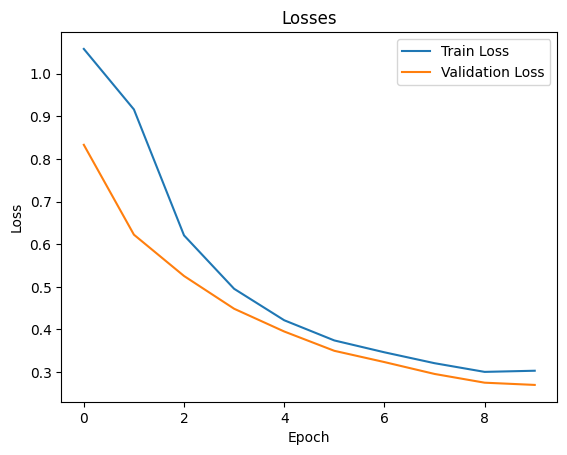

In [30]:
model = BreastCancerClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.BCEWithLogitsLoss()

# We will train the model for 100 epochs
n_epochs = 10
train_losses = []
validation_losses = []

for epoch in range(1, n_epochs + 1):
    # Train the model
    model.train()
    epoch_loss_train = 0  # Accumulate the loss for this epoch
    for batch_x, batch_y in dataloader_train:
        # Add your code here for a single training step. Make sure the loss is placed in
        # the loss_value variable.
        # ---
        optimizer.zero_grad()
        y_pred = model(batch_x)
        loss_value = loss_function(y_pred.squeeze(), batch_y)
        loss_value.backward()
        optimizer.step()
        # ---
        epoch_loss_train += loss_value.item()

    avg_epoch_loss_train = epoch_loss_train / len(dataloader_train)  # Average loss for the epoch
    train_losses.append(avg_epoch_loss_train)

    # Evaluate the model
    model.eval()
    epoch_loss_validation = 0
    with torch.no_grad():
        for batch_x, batch_y in dataloader_validation:
            # Add your code here for a single validation step. Make sure the loss is placed in
            # the loss_value variable.
            # ---
            y_pred = model(batch_x)
            loss_value = loss_function(y_pred.squeeze(), batch_y)
            # ---
            epoch_loss_validation += loss_value.item()

    avg_epoch_loss_validation = epoch_loss_validation / len(dataloader_validation)
    validation_losses.append(avg_epoch_loss_validation)

    print(f"Epoch {epoch}: Train Loss: {avg_epoch_loss_train:.4f}, Validation Loss: {avg_epoch_loss_validation:.4f}")

# Calculate the AUC score on the full validation set
x = data_validation[:][0]
y = data_validation[:][1]
y_pred = model(x)
print(f"ROC-AUC score: {roc_auc_score(y.numpy(), y_pred.detach().numpy()):.4f}")

# Plot the learning curves
pd.DataFrame({
    "Train Loss": train_losses,
    "Validation Loss": validation_losses,
}).plot(title="Losses", xlabel="Epoch", ylabel="Loss")